# Le Nguyen
# STT 381
# 4/18/21

# Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor


# 1. Data Exploration

The dataset used in this project was 538's police killings dataset found here: https://github.com/fivethirtyeight/data/tree/master/police-killings

Article using the data:
https://fivethirtyeight.com/features/where-police-have-killed-americans-in-2015/

Before forming a problem statement about the data, I want to explore what the data looks like to see if there are any visible trends.

# Police Killings, Data Description

This directory contains the data behind the story [Where Police Have Killed Americans In 2015](http://fivethirtyeight.com/features/where-police-have-killed-americans-in-2015).

We linked entries from the [Guardian's database on police killings](http://www.theguardian.com/us-news/ng-interactive/2015/jun/01/the-counted-map-us-police-killings) to census data from the American Community Survey. The Guardian data was downloaded on June 2, 2015. More information about its database is available [here](http://www.theguardian.com/us-news/ng-interactive/2015/jun/01/about-the-counted).

Census data was calculated at the tract level from the 2015 5-year American Community Survey using the tables `S0601 (demographics)`, `S1901 (tract-level income and poverty)`, `S1701 (employment and education)` and `DP03 (county-level income)`. Census tracts were determined by geocoding addresses to latitude/longitude using the Bing Maps and Google Maps APIs and then overlaying points onto 2014 census tracts. GEOIDs are census-standard and should be easily joinable to other ACS tables -- let us know if you find anything interesting.

Header | Description | Source
---|-----------|----
`name` | Name of deceased | Guardian
`age` | Age of deceased | Guardian
`gender` | Gender of deceased | Guardian
`raceethnicity` | Race/ethnicity of deceased | Guardian
`month` | Month of killing | Guardian
`day` | Day of incident | Guardian
`year` | Year of incident | Guardian
`streetaddress` | Address/intersection where incident occurred | Guardian
`city` | City where incident occurred | Guardian
`state` | State where incident occurred | Guardian
`latitude` | Latitude, geocoded from address |
`longitude` | Longitude, geocoded from address |
`state_fp` | State FIPS code | Census
`county_fp` | County FIPS code | Census
`tract_ce` | Tract ID code | Census
`geo_id` | Combined tract ID code |
`county_id` | Combined county ID code |
`namelsad` | Tract description | Census
`lawenforcementagency` | Agency involved in incident | Guardian
`cause` | Cause of death | Guardian
`armed` | How/whether deceased was armed | Guardian
`pop` | Tract population | Census
`share_white` | Share of pop that is non-Hispanic white | Census
`share_bloack` | Share of pop that is black (alone, not in combination) | Census
`share_hispanic` | Share of pop that is Hispanic/Latino (any race) | Census
`p_income` | Tract-level median personal income | Census
`h_income` | Tract-level median household income | Census
`county_income` | County-level median household income | Census
`comp_income` | `h_income` / `county_income` | Calculated from Census
`county_bucket` | Household income, quintile within county | Calculated from Census
`nat_bucket` | Household income, quintile nationally | Calculated from Census

`comp_income` is simply tract-level median household income as a share of county-level median household income.

`county_bucket` provides where the tract's median household income falls in the distribution (by quintile) of all tracts in the county. (1 indicates a tract falls in the poorest 20% of tracts within the county.) Distribution is not weighted by population.

`nat_bucket` is the same but for all U.S. counties.

In [24]:
#Importing the data
Data = pd.read_csv("killings.csv")
Data.head()

,name,age,gender,raceethnicity,month,day,year,streetaddress,city,state,...,share_hispanic,p_income,h_income,county_income,comp_income,county_bucket,nat_bucket,pov,urate,college
0,A'donte Washington,16,Male,Black,February,23,2015,Clearview Ln,Millbrook,AL,...,5.6,28375,51367.0,54766,0.937936,3.0,3.0,14.1,0.097686,0.168510
1,Aaron Rutledge,27,Male,White,April,2,2015,300 block Iris Park Dr,Pineville,LA,...,0.5,14678,27972.0,40930,0.683411,2.0,1.0,28.8,0.065724,0.111402
2,Aaron Siler,26,Male,White,March,14,2015,22nd Ave and 56th St,Kenosha,WI,...,16.8,25286,45365.0,54930,0.825869,2.0,3.0,14.6,0.166293,0.147312
3,Aaron Valdez,25,Male,Hispanic/Latino,March,11,2015,3000 Seminole Ave,South Gate,CA,...,98.8,17194,48295.0,55909,0.863814,3.0,3.0,11.7,0.124827,0.050133
4,Adam Jovicic,29,Male,White,March,19,2015,364 Hiwood Ave,Munroe Falls,OH,...,1.7,33954,68785.0,49669,1.384868,5.0,4.0,1.9,0.063550,0.403954


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


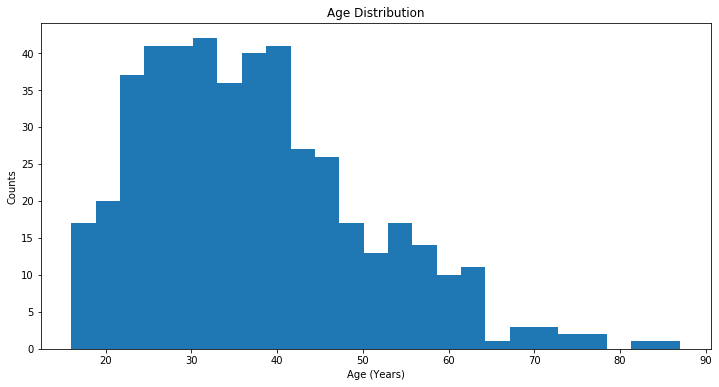

In [26]:
#Age
plt.figure(figsize = (12,6))

Data['age'] = pd.to_numeric(Data["age"],errors='coerce')
plt.hist(Data['age'], bins = 25)
plt.title("Age Distribution")
plt.ylabel("Counts")
plt.xlabel("Age (Years)");

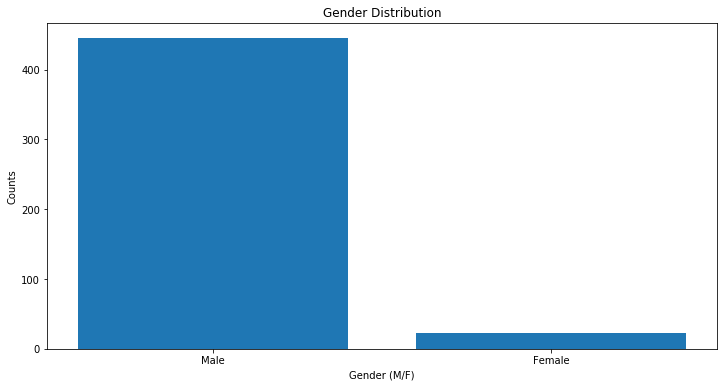

In [27]:
#Gender
plt.figure(figsize = (12,6))

plt.bar(["Male","Female"], [len(Data[Data["gender"] == "Male"]),len(Data[Data["gender"] == "Female"])])
plt.title("Gender Distribution")
plt.ylabel("Counts")
plt.xlabel("Gender (M/F)");

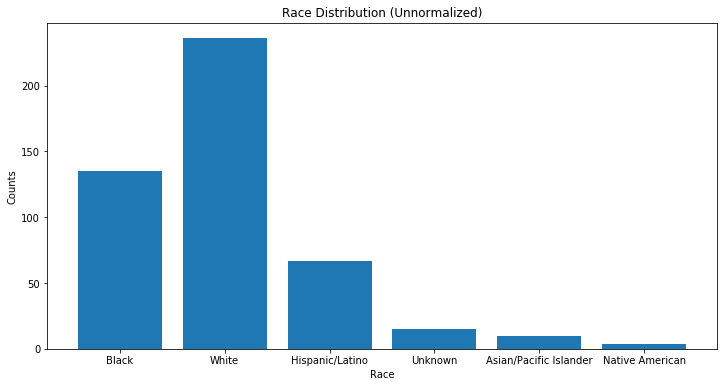

In [28]:
#Race distribution (Unnormalized)
Races = Data["raceethnicity"].unique()

RaceCount = []

for i in Races:
    Count = Data[Data["raceethnicity"] == i]
    RaceCount.append(len(Count))


plt.figure(figsize = (12,6))

plt.bar(Races,RaceCount);
plt.title("Race Distribution (Unnormalized)")
plt.ylabel("Counts")
plt.xlabel("Race");

When I was looking at race in the data, I wanted to normalize each race against the percentage of the population they were in 2016. I used census data to convert the absolute number of people killed per race into people killed per race per 100,000 thosand.

https://www.statista.com/statistics/270272/percentage-of-us-population-by-ethnicities/

In [8]:
#Estimate population of U.S. 2015  
Pop= 323*10**6
#Estimate population per 100,000
RaceCountAdjusted = (np.array(RaceCount)/np.array([.1331*Pop,.6127*Pop,.1779*Pop,.06*Pop,.0567*Pop,.0125*Pop]))*10**5

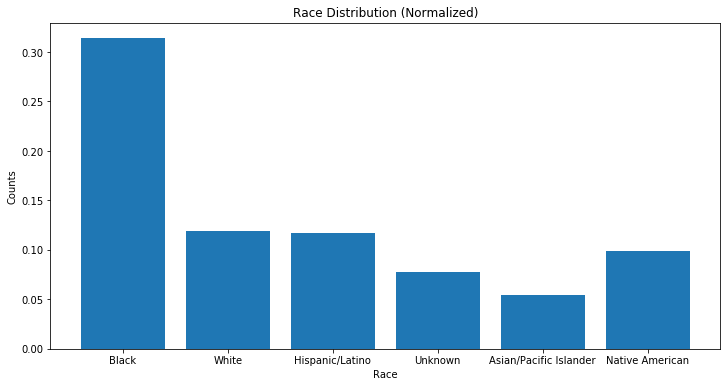

In [29]:
#Distribution in the data (Adjusted by population (per 100,000))
plt.figure(figsize = (12,6))

plt.bar(Races,RaceCountAdjusted)
plt.title("Race Distribution (Normalized)")
plt.ylabel("Counts")
plt.xlabel("Race");



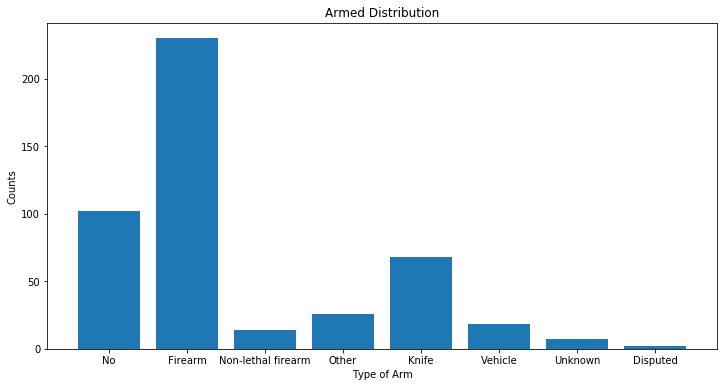

In [30]:
#Armed Distribution
plt.figure(figsize = (12,6))
Data["armed"].unique()
ArmedCount = []

for i in Data["armed"].unique():
    ArmedCount.append(len(Data[Data['armed'] == i]))

plt.bar(Data["armed"].unique(), ArmedCount)
plt.title("Armed Distribution")
plt.ylabel("Counts")
plt.xlabel("Type of Arm");

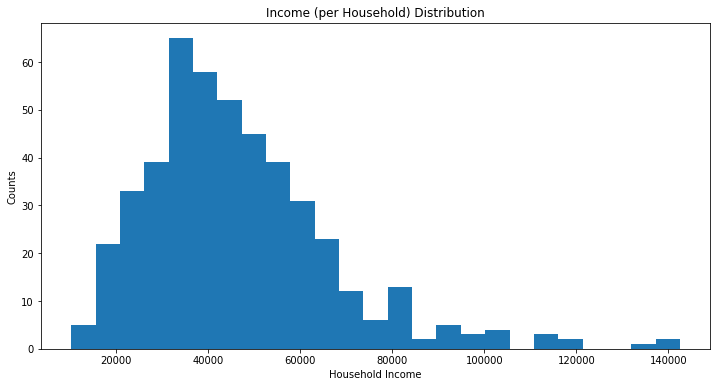

In [31]:
#Income Distribution
plt.figure(figsize = (12,6))
plt.hist(Data["h_income"], bins = 25)
plt.title("Income (per Household) Distribution")
plt.ylabel("Counts")
plt.xlabel("Household Income");

# 2. Problem Statement

After exploring the data and seeing the distribution of variables in dataset I think I will be able to predict the number of people who will be killed by the police given their demographics. Looking at each characteristic on its own lets us see how one variable is related to the frequency of police killings. I think a comprehensive model can be made off of using multiple variables. For example, how many black, young, low income, people do we expect to be killed (in a 5 year span as this data shows)? 

# 3. Related work 

To check the findings of the study this data was used for, I went line by line on the conclusions section of the active to see if I could find the same trends in the data they did.

The conclusion 538 found is the following:

"One thing that’s clear from the data: Police killings tend to take place in neighborhoods that are poorer and blacker than the U.S. as a whole. About 30 percent of the killings — 139 of the 467 — took place in census tracts that are in the bottom 20 percent nationally in terms of household income.4 A quarter of those killed by police died in tracts with majority-black populations; nationally, just 7 percent of the population lives in majority-black tracts.

Black Americans were especially likely to be killed in poorer neighborhoods. Of the 136 African-Americans killed by police who are in the Guardian’s database, 56 — more than 40 percent — died in tracts in the poorest 20 percent nationally. But that may say more about overall racial inequality than about policing per se: African-Americans were killed in low-income areas at roughly the same rate that they live in them.5"

# 3.1 "About 30 percent of the killings — 139 of the 467 — took place in census tracts that are in the bottom 20 percent nationally in terms of household income"

The first statement in the conclusion easily comes out of the dataset, seen below.

People in the bottom quintile 139.0
Total people in the dataset 467


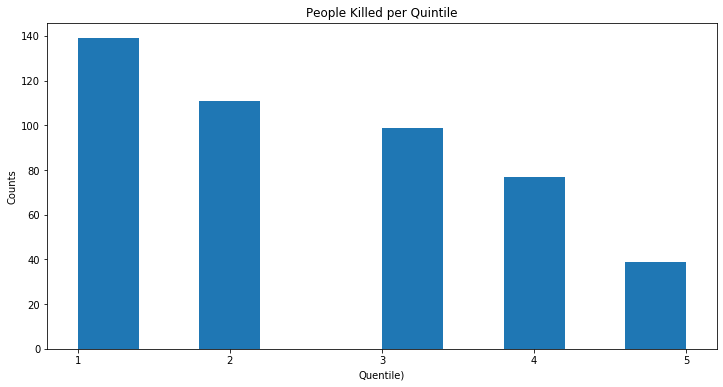

In [38]:
plt.figure(figsize = (12,6))
Data["nat_bucket"] = pd.to_numeric(Data["nat_bucket"], errors = 'coerce')
x,y,_ =plt.hist(Data["nat_bucket"])
plt.xticks([1,2,3,4,5])
plt.title("People Killed per Quintile")
plt.ylabel("Counts")
plt.xlabel("Quentile)");
print("People in the bottom quintile " + str(x[0]))
print("Total people in the dataset " + str(len(Data)))

# 3.2  "A quarter of those killed by police died in tracts with majority-black populations"

I could not prove this claim by the article. I defined a majority-black tract as a tract with a larger share of the poplution that is black than white or hispanic. By doing thing, I found that only about a fifth (20.77%) died in majority-black tracts. I suspect the article is using a different definition of majority-black, which was not stated. 

People died in majority-black tracts 20.77087794432548%


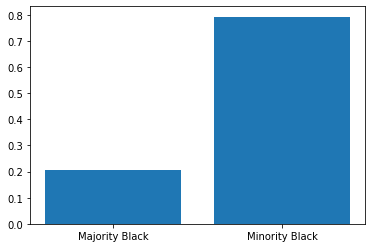

In [41]:
MajorityBlack = 0
MinorityBlack = 0

for i in range(0,len(Data)):
    if Data["share_black"][i] > Data["share_white"][i] and Data["share_black"][i] > Data["share_hispanic"][i]:
        MajorityBlack += 1
    else:
        MinorityBlack += 1 


plt.bar(['Majority Black', 'Minority Black'], np.array([MajorityBlack,MinorityBlack])/len(Data))
print("People died in majority-black tracts " + str(100*MajorityBlack/len(Data["share_black"]))+"%");

# 3.3 "Of the 136 African-Americans killed by police who are in the Guardian’s database, 56 — more than 40 percent — died in tracts in the poorest 20 percent nationally."

This claim was easily proved by masking the data, as seen below.


In [43]:
Poor20 = Data[Data["nat_bucket"] == 1]
print("Number of people in the poorest quintile " + str(len(Poor20)))

Black = Data[Data["raceethnicity"] == "Black"]
print("Number of Black people in the data " +str(len(Black)))

BlackPoor = Black[Black["nat_bucket"] == 1]
print("Number of Black people in the poorest quintile " + str(len(BlackPoor)))

print("Perctange of pooerest quintile that is Black " + str(100*len(BlackPoor)/len(Poor20)) + "%")

Number of people in the poorest quintile 139
Number of Black people in the data 135
Number of Black people in the poorest quintile 56
Perctange of pooerest quintile that is Black 40.28776978417266%


# 4. Model

As said in the problem statement, I wanted to create a multi-variable model to predict the number of people who will be killed by the police in the same time frame as the data looks at (in 5 years). To do this I used a decision tree classifier based on a set of variables that in combination would desribed how many people are killed. The variables I chose were race, age, and household income because they showed very clear trends in the data exlporation. In order to make a classifier I have to further categorize the data in a way the decision tree could use. 

I mapped each race to a number, with 6 races represented they were mapped to 0-5. I then had to categorize age, which I did with young (0-35), middle aged (36-65), and old (65+). A similar categorization was given to household income: low (0-30k), medium (30k-80k) and high (80k+). Each low/medium/high classificaton was mapped from 0-2. So my features now looked like a list of categories. Like 1,2,2, would be a white, middle aged, medium income person. 

The labels for the data were the number of people with a certian set of characteristics that were killed. This was determined by the number of rows in the data with the exact same characteristics. With the labels and features, I was able to create a classifier to predict how many people of a certian set of characteristics would die in a 5 year span by police. 


In [15]:
#0 = Black
#1 = White
#2 = Hispanic/Latino
#3 = Unkown
#4 = Asian/Pacific Islander
#5 = Native American

RaceNumber = np.array(Data["raceethnicity"])

for j in range(0, len(RaceNumber)):
    for i in range(0,len(Data['raceethnicity'].unique())):
        if RaceNumber[j] == str(Data['raceethnicity'].unique()[i]):
            RaceNumber[j] = i

In [16]:
#0 = young
#1 = middle age
#2 = old

AgeGroup = []

Ages = pd.to_numeric(Data['age'], errors = "coerce")

for i in Ages:
    if i <= 35:
        AgeGroup.append(0)
    elif i > 35 and i <= 65:
        AgeGroup.append(1)
    else:
        AgeGroup.append(2)


In [17]:
#0 = low income
#1 = middle income
#2 = high income

IncomeGroup = []

for i in Data["h_income"]:
    if i <= 30000:
        IncomeGroup.append(0)
    elif i > 30000 and i <= 80000:
         IncomeGroup.append(1)
    else:
        IncomeGroup.append(2)



In [18]:
ModelData = pd.DataFrame(np.array([AgeGroup,RaceNumber,IncomeGroup]).T, columns = ["age","race","income"])
ModelData.head()

,age,race,income
0,0,0,1
1,0,1,0
2,0,1,1
3,0,2,1
4,0,1,1


In [19]:
#Counting duplicate rows
Duplicates = []

for i in range(0, len(ModelData)):
    Counts = 0
    for j in range(0, len(ModelData)):
        if ModelData.loc[i][0] == ModelData.loc[j][0] and ModelData.loc[i][1] == ModelData.loc[j][1] and ModelData.loc[i][2] == ModelData.loc[j][2]:
            Counts +=1
    Duplicates.append(Counts)
    
Duplicates 
ModelData.insert(3,"counts",Duplicates)

In [20]:
ModelData

,age,race,income,counts
0,0,0,1,49
1,0,1,0,14
2,0,1,1,75
3,0,2,1,35
4,0,1,1,75
...,...,...,...,...
462,0,0,0,26
463,0,5,1,2
464,1,1,1,105
465,1,0,1,34


In [21]:
#Training and testing classifier
Filtered = ModelData
Filtered = Filtered.mask(Filtered['age'] == 'Unknown')
Filtered = Filtered.dropna()
Filtered = Filtered.sample(frac = 1)

X = Filtered[['age','race','income']]
Y = Filtered['counts']
Y=Y.astype('int')

XTrain = X[0:300]
YTrain = Y[0:300]

XTest = X[301:]
YTest = Y[301:]

Classifier = tree.DecisionTreeClassifier()
Fit = Classifier.fit(XTrain, YTrain)
Fit.score(XTest,YTest)

0.9698795180722891

# 5. Results

My model was built with a 2/3:1/3 train-test split and to check the accuracy of the model I retrained and retested the model 1,000 times. Each time the data was randomly shuffled to make sure the model could be trained and tested on any data and still work. 

After training and testing on 1,000 reshuffles of the data, I got a mean accuracy of about 97.71% with a standard deviation of 1.31%

Mean Score: 0.9771746987951808
Varience: 0.013198792431249131


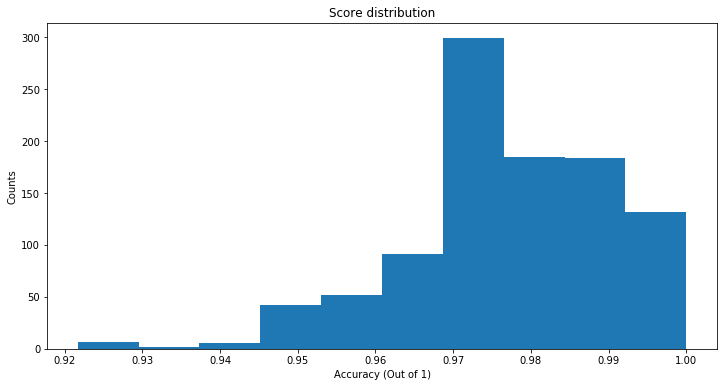

In [54]:
#Repeating the training and testing to see if I get consistant results.
Scores = []
for i in range(0,1000):
    Filtered = ModelData
    Filtered = Filtered.mask(Filtered['age'] == 'Unknown')
    Filtered = Filtered.dropna()
    Filtered = Filtered.sample(frac = 1)

    X = Filtered[['age','race','income']]
    Y = Filtered['counts']
    Y=Y.astype('int')

    XTrain = X[0:300]
    YTrain = Y[0:300]

    XTest = X[301:]
    YTest = Y[301:]

    Classifier = tree.DecisionTreeClassifier()
    Fit = Classifier.fit(XTrain, YTrain)
    Scores.append(Fit.score(XTest,YTest))

plt.figure(figsize = (12,6))
plt.hist(Scores)
plt.title("Score distribution")
plt.ylabel("Counts")
plt.xlabel("Accuracy (Out of 1)");
print("Mean Score: " + str(np.mean(Scores)))
print("Varience: " + str(np.std(Scores)))

# 6. Discussion and conclusions

I think the high accuracy of my model is misleading because of the size and repetition of the data set. With only 467 enteries, I am not working with much data and with the catagorization of my data I made my labels very limited. One set of characteristics is found in the data 105 times, meaning about 1/5 of the data is identical. I think this model would be greatly improved with much more data, finer catagorization, and more variables included. 